In [42]:
import operator
from typing import Dict, List

import pandas as pd
import yfinance as yf
from tools import roc, sma

In [43]:
INIT_DEPOT = 10_000
START_DATE = "2018-01-01"
END_DATE = "2024-01-01"

In [44]:
def ndx100_list():
    table = pd.read_html("https://en.wikipedia.org/wiki/Nasdaq-100#Components")[4]
    return list(table.Ticker)

In [45]:
import pickle

with open("nasdaq_100_historical.pkl", "rb") as file:
    nasdaq_100_symbols = pickle.load(file)

In [46]:
def stock_score(data: pd.DataFrame) -> pd.Series:
    return roc(data.Close, 100)

In [47]:
def resample_index_to_month(df: pd.DataFrame) -> pd.DataFrame:
    df["Date"] = df.index
    df["month"] = df["Date"].dt.strftime("%y-%m")

    df = df.groupby("month").agg(
        Date=("Date", "last"),
        Close=("Close", "last"),
        above_sma=("above_sma", "last"),
    )
    return df.reset_index().set_index("Date").sort_index()

In [48]:
def resample_stocks_to_month(df: pd.DataFrame) -> pd.DataFrame:
    df["Date"] = df.index
    df["month"] = df["Date"].dt.strftime("%y-%m")

    df = df.groupby("month").agg(
        Date=("Date", "last"),
        Open=("Open", "first"),
        Close=("Close", "last"),
        score=("score", "last"),
    )
    return df.reset_index().set_index("Date").sort_index()

In [49]:
def get_stocks(symbols: List[str]) -> Dict[str, pd.DataFrame]:
    """_summary_

    Args:
        symbols (List[str]): _description_

    Returns:
        Dict[str, pd.DataFrame]: _description_
    """

    dfs = {}
    stock_data = yf.download(
        symbols,
        rounding=2,
        progress=False,
        group_by="ticker",
    )

    # perform some pre preparation
    for symbol in stock_data.columns.get_level_values(0).unique():
        # drop unclear items
        df = stock_data[symbol]
        df = df[~(df.High == df.Low)]
        df = df.dropna()
        df.index = pd.to_datetime(df.index)

        dfs[symbol.lower()] = df

    return dfs

In [50]:
sp_500 = yf.download("^GSPC")
sp_500 = yf.download("SPY")
ndx_100 = yf.download("^NDX")

sp_500["above_sma"] = sp_500.Close > sma(sp_500.Close, 275)
sp_500["sma"] = sma(sp_500.Close, 275)

sp_500 = sp_500[START_DATE:END_DATE]
ndx_100 = ndx_100[START_DATE:END_DATE]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [51]:
"""sp_500["Date"] = sp_500.index
sp_500["month"] = sp_500["Date"].dt.strftime("%y-%m")

test = sp_500.groupby("month").agg(
    Date=("Date", "last"),
    Close=("Close", "last"),
    above_sma=("above_sma", "last"),
    sma=("sma", "last"),

).reset_index().set_index("Date").sort_index()

test ['2020-01-01': '2021-01-01']"""

'sp_500["Date"] = sp_500.index\nsp_500["month"] = sp_500["Date"].dt.strftime("%y-%m")\n\ntest = sp_500.groupby("month").agg(\n    Date=("Date", "last"),\n    Close=("Close", "last"),\n    above_sma=("above_sma", "last"),\n    sma=("sma", "last"),\n\n).reset_index().set_index("Date").sort_index()\n\ntest [\'2020-01-01\': \'2021-01-01\']'

In [52]:
sp_500 = resample_index_to_month(sp_500)

In [53]:
# stocks = get_stocks(ndx100_list())
stocks = get_stocks(nasdaq_100_symbols["all"])


25 Failed downloads:
['WLTW', 'VIAB', 'CERN', 'XLNX', 'NLOK', 'ALXN', 'DISCK', 'LMCK', 'BBBY', 'CTXS', 'CELG', 'YHOO', 'GHEC', 'MYL', 'FB', 'MXIM', 'DISCA', 'RVIN']: Exception('%ticker%: No timezone found, symbol may be delisted')
['LMCA', 'SNDK', 'LLTC', 'WFM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1925-05-16 -> 2024-04-22)')
['ATVI', 'DISH', 'SGEN']: Exception('%ticker%: No data found, symbol may be delisted')


In [54]:
tracker = sp_500[["above_sma", "month"]]

for symbol, df in stocks.items():
    df["score"] = stock_score(df)
    df = resample_stocks_to_month(df)
    df[symbol] = df["score"]

    # Add score to tracker
    tracker = pd.merge(
        tracker, df[[symbol]], left_index=True, right_index=True, how="left"
    )
    tracker["next"] = tracker.month

In [55]:
start_depot = INIT_DEPOT
depot_development = []
MAX_STOCKS = 10
transactions = []

for index, row in tracker[tracker.above_sma == 1].iterrows():
    active_period = row["next"]
    current_symbols = dict(row)
    current_symbols.pop("above_sma")
    current_symbols.pop("next")
    current_symbols.pop("month")

    montly_basket = {}
    symbols = []
    monthly_investment = 0

    transactions.append(
        {"month": active_period, "symbol": "CASH", "qty": 1, "sum": start_depot}
    )

    # current month symbols
    active_symbols = list(
        set(tracker.columns).intersection(
            [x.lower() for x in nasdaq_100_symbols[active_period]]
        )
    )

    current_symbols = {k: v for (k, v) in current_symbols.items() if v > 0}

    # Sort the symbols by their score
    top_stocks = sorted(current_symbols.items(), key=operator.itemgetter(1))

    for symbol in [ticker for (ticker, _) in top_stocks[-MAX_STOCKS:]]:
        df = stocks[symbol]

        buy_price = df[df.month == active_period].Open.values[0]
        sell_price = df[df.month == active_period].Close.values[-1]

        qty = (start_depot / MAX_STOCKS) // buy_price
        monthly_investment += qty * -buy_price
        monthly_investment += qty * sell_price

        transactions.append(
            {
                "month": active_period,
                "symbol": symbol,
                "qty": (start_depot / MAX_STOCKS) // buy_price,
                "buy_price": buy_price,
                "sell_price": sell_price,
                "sum": round(qty * (sell_price - buy_price), 2),
            }
        )
        symbols.append(symbol)

    start_depot = round(start_depot + monthly_investment, 2)
    depot_development.append({"month": active_period, "Total_mix": start_depot})

    # print(symbols)

In [56]:
transactions = pd.DataFrame(transactions)
transactions[["month", "symbol", "qty", "buy_price", "sell_price", "sum"]].to_csv(
    "transaction.csv", sep=";", decimal=",", index=False
)
transactions.groupby("month").agg(
    sum=("sum", "sum"),
)

,sum
month,
18-01,11841.20
18-02,13171.90
18-03,14889.75
18-04,15277.64
18-05,19736.80
18-06,20847.93
18-07,21595.53
18-08,28633.30
18-09,30951.89


In [57]:
transaction_monthly = transactions.groupby(["month", "symbol"]).agg(
    sum=("sum", "sum"),
)

transaction_monthly

sum
month symbol          
18-01 CASH    10000.00
      amzn      236.98
      enph      -79.42
      meli      208.83
      mtch      106.64
...                ...
23-12 panw     1824.70
      pdd      4329.52
      splk     1233.90
      trip    43796.25
      zs      24829.83

[594 rows x 1 columns]

In [58]:
depot_development = pd.DataFrame(depot_development)
depot_development = pd.merge(
    sp_500[["month"]].copy().reset_index(), depot_development, on="month", how="left"
).set_index("Date")

depot_development.loc[depot_development.iloc[0].name, "Total_mix"] = INIT_DEPOT
depot_development["Total_mix"] = depot_development["Total_mix"].ffill()

In [59]:
sp_500["Cum Return"] = sp_500["Close"] / sp_500.iloc[0].Close
sp_500["Cum Return %"] = (sp_500["Cum Return"] - 1) * 100
sp_500["Total"] = (sp_500["Cum Return"] * INIT_DEPOT).round()

ndx_100["Cum Return"] = ndx_100["Close"] / ndx_100.iloc[0].Close
ndx_100["Cum Return %"] = (ndx_100["Cum Return"] - 1) * 100
ndx_100["Total"] = (ndx_100["Cum Return"] * INIT_DEPOT).round()

<Axes: title={'center': 'Portfolio'}, xlabel='Date'>

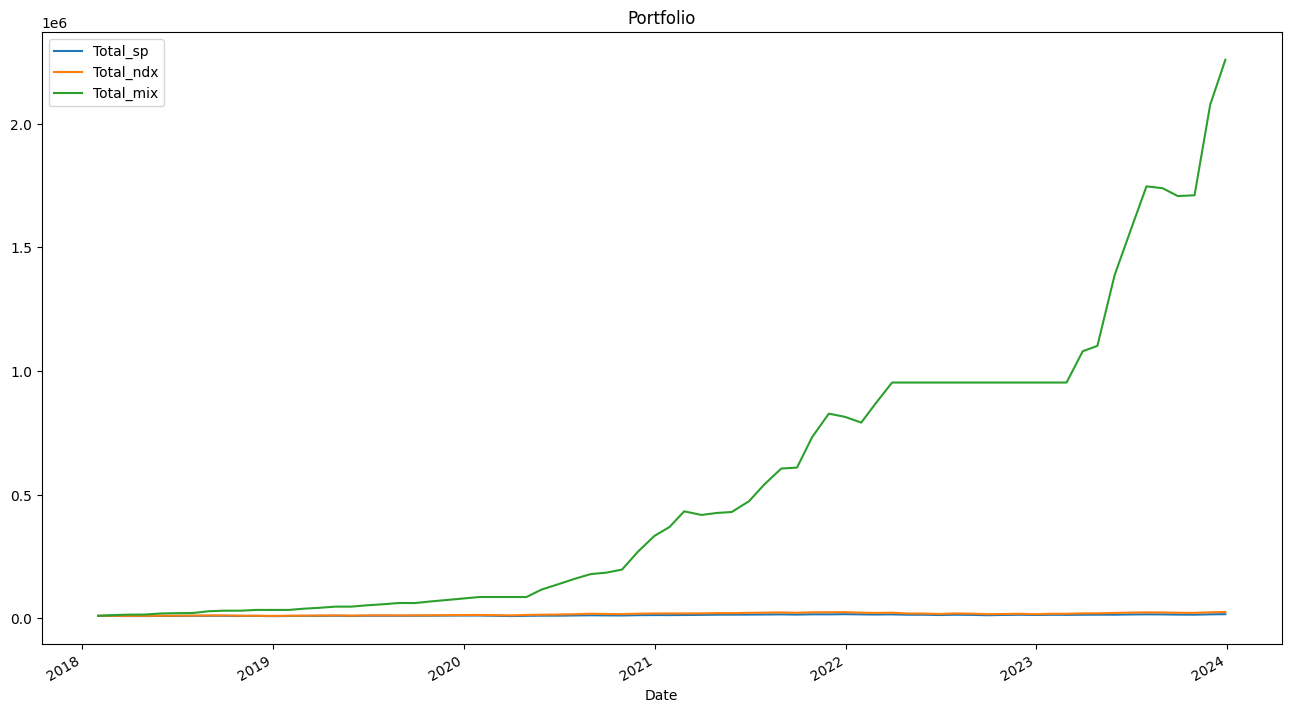

In [60]:
portfolio = pd.merge(
    sp_500[["Total", "month"]],
    ndx_100[["Total"]],
    left_index=True,
    right_index=True,
    suffixes=("_sp", "_ndx"),
)

portfolio = pd.merge(
    portfolio,
    depot_development["Total_mix"],
    left_index=True,
    right_index=True,
)

portfolio.plot(title="Portfolio", figsize=(16, 9))